<a href="https://colab.research.google.com/github/Kotakageyama/sakata_goho_chart/blob/main/CryptoBOT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ドライブをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 必要なライブラリをインストールする

In [ ]:
%%capture
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ../
%rm -rf ta-lib-0.4.0-src.tar.gz
%rm -rf ta-lib
!pip install Ta-Lib

In [ ]:
%%capture
!pip install backtesting
!pip install ccxt
!pip install mplfinance
!pip install pyti
!pip install keras
!pip install pandas_ta
!pip install ta

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplfinance as mpf
%matplotlib inline

from pyti.bollinger_bands import upper_bollinger_band as bb_up
from pyti.bollinger_bands import middle_bollinger_band as bb_mid
from pyti.bollinger_bands import lower_bollinger_band as bb_low

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#import graphviz
#import talib

import datetime
import time
import requests

import ccxt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from ta import add_all_ta_features

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-cons

# Kucoin APIの設定

In [ ]:
from google.colab import userdata
exchange = ccxt.kucoin({
    'apiKey': userdata.get('KuCoin_API_KEY'),
    'secret': userdata.get('KuCoin_API_SECRET'),
    'password': userdata.get('KuCoin_API_PASSPHRAS'),
})

# 過去データ取得
時間足データ（1時間足、4時間足など）の場合:
- 期間: 2年以上。
- 理由: 日中の変動や短期的なトレンドを学習するため。

In [ ]:
#symbol = 'BTC/USDT'
symbol = 'SOL/USDT'
timeframe = '1d'
# limit = 8760  # データポイント数 1yaer
limit = 8760*2 # 2year

# OHLCVデータ（タイムスタンプ、始値、高値、安値、終値、出来高）を取得
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data = data.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

In [ ]:
data.head(5)
print(len(data))

1187


# モデル作成

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Embedding
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.model_selection import train_test_split
# データの分割
df = data.copy()

# テクニカル指標の計算
df['SMA_10'] = df['Close'].rolling(window=10).mean() # 移動平均線の追加
df['SMA_20'] = df['Close'].rolling(window=20).mean() # 移動平均線の追加
df['RSI'] = ta.rsi(df['Close'], length=14)
df['MACD'] = ta.macd(df['Close'])['MACD_12_26_9']
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

# 欠損値の削除
df.dropna(inplace=True)

# テクニカル指標の追加
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

df.head(20)

# # 特徴量の選択（テクニカル指標を含む）
# feature_columns = data.columns.drop(['Open', 'High', 'Low', 'Close', 'Volume'])
# data_features = data[feature_columns]

/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


,Open,High,Low,Close,Volume,SMA_10,SMA_20,RSI,MACD,ATR,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-29,96.105,97.800,90.143,94.267,138848.419604,79.6472,66.77410,81.363144,17.612436,9.525378,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.267000,0.000000,0.000000,0.000000
2021-08-30,94.248,118.996,93.653,110.145,317955.405419,82.7891,70.24635,86.078647,18.890787,10.847764,...,1.327095,0.265419,1.061676,9.392683,1.878537,7.514147,97.277014,16.843646,15.566650,16.843646
2021-08-31,110.369,130.499,103.102,108.234,494295.682035,86.2249,73.57305,83.345353,19.524620,12.214674,...,2.170449,0.646425,1.524024,22.194035,5.941636,16.252399,99.799269,-1.734986,-1.750213,14.816426
2021-09-01,108.235,119.681,105.980,110.784,260625.311457,90.0404,77.05545,84.072149,20.002129,12.336084,...,2.994595,1.116059,1.878536,21.762440,9.105797,12.656643,102.424670,2.356006,2.328681,17.521508
2021-09-02,110.722,133.682,108.962,128.230,308381.852774,95.3004,81.21950,87.947387,21.540005,13.337387,...,4.937309,1.880309,3.057000,22.692291,11.823096,10.869195,105.344166,15.747761,14.624317,36.028515
2021-09-03,128.277,148.982,128.118,146.287,416323.907034,102.8704,86.31995,90.518647,23.939868,13.940268,...,7.636954,3.031638,4.605316,26.195639,14.697604,11.498034,107.315436,14.081728,13.174492,55.183680
2021-09-04,146.274,150.614,135.823,138.976,227548.577217,109.5687,90.55925,82.815109,24.964069,14.007826,...,8.997893,4.224889,4.773004,22.710580,16.300200,6.410380,108.895525,-4.997710,-5.126919,47.428050
2021-09-05,138.976,145.000,134.770,142.059,213260.195711,116.3032,94.55185,83.454567,25.727953,13.710200,...,10.088118,5.397535,4.690583,19.294333,16.899026,2.395307,109.967637,2.218369,2.194121,50.698548
2021-09-06,142.065,166.076,137.011,164.276,301977.734088,123.9267,99.55285,87.161904,27.805538,14.911058,...,12.171553,6.752338,5.419214,19.156167,17.350455,1.805713,110.243939,15.639277,14.530548,74.266711


In [ ]:
# 特徴量とターゲットの選択
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'RSI', 'MACD', 'ATR']
target = 'Close'

# データのスケーリング
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# スケーリング済みのデータをDataFrameに戻す
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

# ターゲットのスケーリング
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(df[[target]])

# 入力シーケンスとターゲットの作成
# 大量データの中から予測に利用する枠を指定
sequence_length = 60  # 60日間のデータを使用して次の日を予測

X = []
y = []

for i in range(sequence_length, len(scaled_df)-1):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_target[i+1])  # 一つ先の時点のClose価格

X = np.array(X)
# 機械学習用に1次元配列を2次元配列にしている
y = np.array(y).reshape(-1, 1)

In [ ]:
# トレーニングセットとテストセットの分割
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Transformerのハイパーパラメータ
d_model = X_train.shape[2]  # 特徴量の次元数
num_heads = 4
ff_dim = 32
dropout_rate = 0.1

# 入力レイヤー
inputs = Input(shape=(sequence_length, d_model))

# マルチヘッド注意機構
attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
attention_output = Dropout(dropout_rate)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

# フィードフォワードネットワーク
ffn_output = Dense(ff_dim, activation='relu')(attention_output)
ffn_output = Dense(d_model)(ffn_output)
ffn_output = Dropout(dropout_rate)(ffn_output)
ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)

# 出力レイヤー
avg_pool = GlobalAveragePooling1D()(ffn_output)
outputs = Dense(1)(avg_pool)

# モデルの定義
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
# モデルの訓練
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.7784 - val_loss: 0.0167
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0526 - val_loss: 0.0061
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0321 - val_loss: 0.0109
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0270 - val_loss: 0.0084
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0245 - val_loss: 0.0065
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0224 - val_loss: 0.0103
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0215 - val_loss: 0.0048
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0193 - val_loss: 0.0055
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0170 - val_loss: 0.0061
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0157 - val_loss: 0.0060
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0168 - val_loss: 0.0089
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

## modelを保存する

In [ ]:
from datetime import datetime

# 現在の日付を文字列に変換（フォーマットを指定）
current_date = datetime.now()

# モデルの保存先のパスを指定（Google Driveのマウント先を使用）
model_save_path = f'/content/drive/MyDrive/Colab Notebooks/ModelsBox/Transformer_{current_date}.keras'

# モデルの保存
model.save(model_save_path)


## modelでロードする

In [ ]:
from keras.models import load_model

# Google Driveからモデルをロード
model = load_model('/content/drive/MyDrive/Colab Notebooks/ModelsBox/Transformer_2024-10-16 01:48:52.279181.keras')


## モデルで予測する

In [ ]:
# モデルの評価
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# 予測の実行
y_pred = model.predict(X_test)

# スケーリングを元に戻す
# y_test_unscaled = scaler.inverse_transform(
#     np.concatenate((np.zeros((len(y_test), len(features)-1)), y_test.reshape(-1, 1)), axis=1)
# )[:, -1]

# y_pred_unscaled = scaler.inverse_transform(
#     np.concatenate((np.zeros((len(y_pred), len(features)-1)), y_pred), axis=1)
# )[:, -1]

# 予測結果と実際の値を逆スケーリング
y_test_unscaled = target_scaler.inverse_transform(y_test)
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0406 
Test Loss: 0.03574970364570618
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


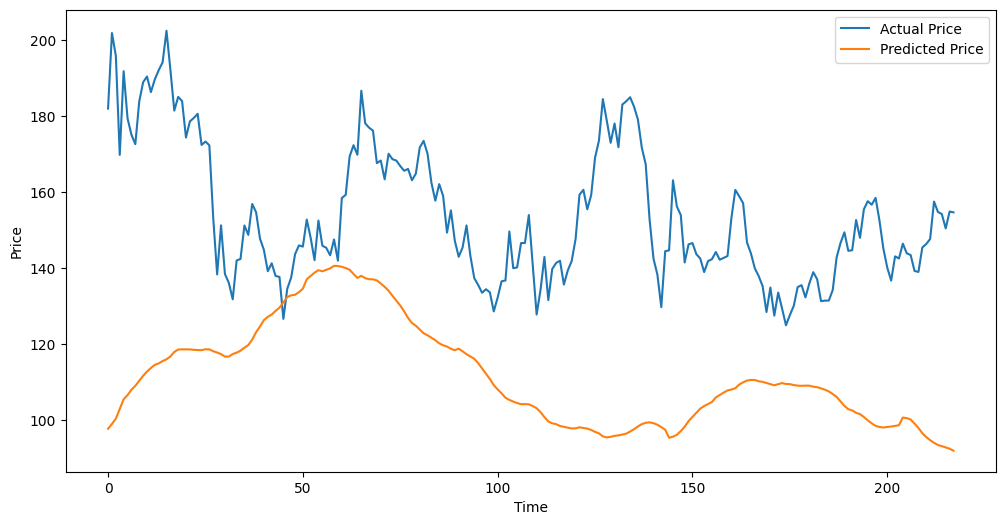

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Price')
plt.plot(y_pred_unscaled, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# バックテストを実行する
- cash=10000: 初期資金を設定（10,000ドル）。
- commission=0.002: 売買ごとの手数料を0.2%に設定

### Transformer

In [ ]:
from backtesting import Backtest, Strategy

class TransformerStrategy(Strategy):
    def init(self):
        # Transformerモデルから生成されたシグナルを読み込む
        self.signal = self.data.Signal
        self.take_profit = 0.05  # 利確目標 (5%)
        self.stop_loss = 0.02  # 損切り設定 (2%)

    def next(self):
        # 最新のシグナルを取得
        current_signal = self.signal[-1]

        # 買いシグナルが出ていてポジションがない場合は買う
        if current_signal and not self.position:
            # 指定したサイズ（現金の一部）で買い注文を出す
            self.buy(size=self.equity * 0.1 / self.data.Close[-1])  # 資金の10%で買い

        # 損切りと利確の設定
        if self.position:
            entry_price = self.position.price
            current_price = self.data.Close[-1]

            # 利確条件を満たした場合、ポジションを閉じる
            if current_price >= entry_price * (1 + self.take_profit):
                self.position.close()

            # 損切り条件を満たした場合、ポジションを閉じる
            elif current_price <= entry_price * (1 - self.stop_loss):
                self.position.close()

        # 売りシグナルが出ている場合はポジションを閉じる
        if not current_signal and self.position:
            self.position.close()


In [ ]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# def generate_transformer_signals(data, transformer_model, sequence_length=60):
#     """
#     Transformerモデルを用いて売買シグナルを生成する。

#     Parameters:
#     - data: OHLCデータを含むDataFrame（例: 'Open', 'High', 'Low', 'Close', 'Volume'）
#     - transformer_model: 予測に使用する学習済みTransformerモデル
#     - sequence_length: モデルに入力する時系列データのシーケンス長（デフォルトは60）

#     Returns:
#     - signals: 売買シグナル（1: 買い、0: 売り）
#     """

#     # 必要な特徴量を選択（例として'Close', 'Volume'を使用）
#     feature_columns = features
#     data_features = data[feature_columns]

#     # スケーリングの実施（0-1の範囲に正規化）
#     scaler = MinMaxScaler()
#     scaled_data = scaler.fit_transform(data_features)

#     # Transformerに入力するためのシーケンスを作成
#     X = []
#     for i in range(sequence_length, len(scaled_data)):
#         X.append(scaled_data[i-sequence_length:i])

#     # モデルの入力として配列に変換
#     X = np.array(X)

#     # Transformerモデルで予測を行う
#     predictions = transformer_model.predict(X)

#     # 予測結果からシグナルを生成（0.5を閾値とする場合）
#     signals = (predictions > 0.5).astype(int)

#     # signalsをデータの最初から合わせるために、先頭にゼロを挿入
#     # シーケンスの最初の部分には予測がないため、その部分はゼロにする
#     signals = np.concatenate([np.zeros(sequence_length), signals.flatten()])

#     return signals

def generate_transformer_signals(data, transformer_model, sequence_length=60):
    """
    Transformerモデルを用いて売買シグナルを生成する。

    Parameters:
    - data: OHLCデータを含むDataFrame（例: 'Open', 'High', 'Low', 'Close', 'Volume'）
    - transformer_model: 予測に使用する学習済みTransformerモデル
    - sequence_length: モデルに入力する時系列データのシーケンス長（デフォルトは60）

    Returns:
    - signals: 売買シグナル（1: 買い、-1: 売り、0: ホールド）
    """

    # テクニカル指標の追加
    data = add_all_ta_features(
        data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    # 特徴量の選択（テクニカル指標を含む）
    feature_columns = data.columns.drop(['Open', 'High', 'Low', 'Close', 'Volume'])
    data_features = data[feature_columns]

    # データの標準化
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_features)

    # シーケンスデータの作成
    X = []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i - sequence_length:i])

    X = np.array(X)

    # Transformerモデルで予測を実行
    predictions = transformer_model.predict(X)

    # 実際の価格データの取得
    actual_prices = data['Close'].values[sequence_length:]

    # 売買シグナルの生成
    signals = np.zeros(len(predictions))
    for i in range(len(predictions) - 1):
        if predictions[i + 1] > actual_prices[i]:
            signals[i + 1] = 1   # 買いシグナル
        elif predictions[i + 1] < actual_prices[i]:
            signals[i + 1] = -1  # 売りシグナル
        else:
            signals[i + 1] = 0   # ホールド

    # データの長さに合わせてシグナルを調整
    signals = np.concatenate([np.zeros(sequence_length), signals])

    return signals

In [ ]:
print(data)

               Open     High      Low    Close         Volume
timestamp                                                    
2021-08-04   25.000   50.000   25.000   35.799   19984.133565
2021-08-05   35.720   38.300   35.580   37.350   33122.034147
2021-08-06   37.388   40.444   35.710   39.535   28081.027771
2021-08-07   39.402   40.960   37.500   39.333   27779.119633
2021-08-08   39.450   39.517   36.846   37.715   14868.850604
...             ...      ...      ...      ...            ...
2024-10-15  157.583  159.570  150.336  154.826  298319.567909
2024-10-16  154.763  158.375  153.000  154.288  152148.837585
2024-10-17  154.257  155.705  147.699  150.500  167947.546554
2024-10-18  150.500  156.684  149.640  154.943  121836.150751
2024-10-19  154.943  155.075  154.486  154.721     709.078700

[1173 rows x 5 columns]


In [ ]:
# 例としてTransformerモデルからシグナルを生成
backtest_data = df.copy()
signals = generate_transformer_signals(backtest_data, model)

# シグナルをOHLCデータに追加
backtest_data['Signal'] = signals

# バックテストを実行
bt = Backtest(
    backtest_data,
    TransformerStrategy,
    cash=10000,
    commission=.002,
    trade_on_close=True,  # False にするとシグナル発生後の次のバーのオープンで取引をする。default は False.
)

stats = bt.run()
bt.plot()

/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


InvalidArgumentError: Graph execution error:

Detected at node functional_1/multi_head_attention_1/query_1/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-38-637bbc8a7000>", line 3, in <cell line: 3>

  File "<ipython-input-37-de3a18c8fc31>", line 79, in generate_transformer_signals

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/attention/multi_head_attention.py", line 469, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/einsum_dense.py", line 205, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 2305, in einsum

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 322, in einsum

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 213, in use_custom_ops

Matrix size-incompatible: In[0]: [32,60,91], In[1]: [10,40]
	 [[{{node functional_1/multi_head_attention_1/query_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_7662]

### LSTM

In [ ]:
class LSTMStrategy(Strategy):
    def init(self):
        self.signal = self.data.Signal
        self.take_profit = 0.05  # 利確目標 (5%)
        self.stop_loss = 0.02  # 損切り設定 (2%)

    def next(self):
        # 最新のシグナルを取得
        current_signal = self.signal[-1]

        # 買いシグナルが出ていてポジションがない場合は買う
        if current_signal and not self.position:
            # 指定したサイズ（現金の一部）で買い注文を出す
            self.buy(size=self.equity * 0.1 / self.data.Close[-1])  # 資金の10%で買い

        # 損切りと利確の設定
        if self.position:
            entry_price = self.position.price
            current_price = self.data.Close[-1]

            # 利確条件を満たした場合、ポジションを閉じる
            if current_price >= entry_price * (1 + self.take_profit):
                self.position.close()

            # 損切り条件を満たした場合、ポジションを閉じる
            elif current_price <= entry_price * (1 - self.stop_loss):
                self.position.close()

        # 売りシグナルが出ている場合はポジションを閉じる
        if not current_signal and self.position:
            self.position.close()


Start                     2024-08-24 12:00:00
End                       2024-10-05 03:00:00
Duration                     41 days 15:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               -9.689129
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

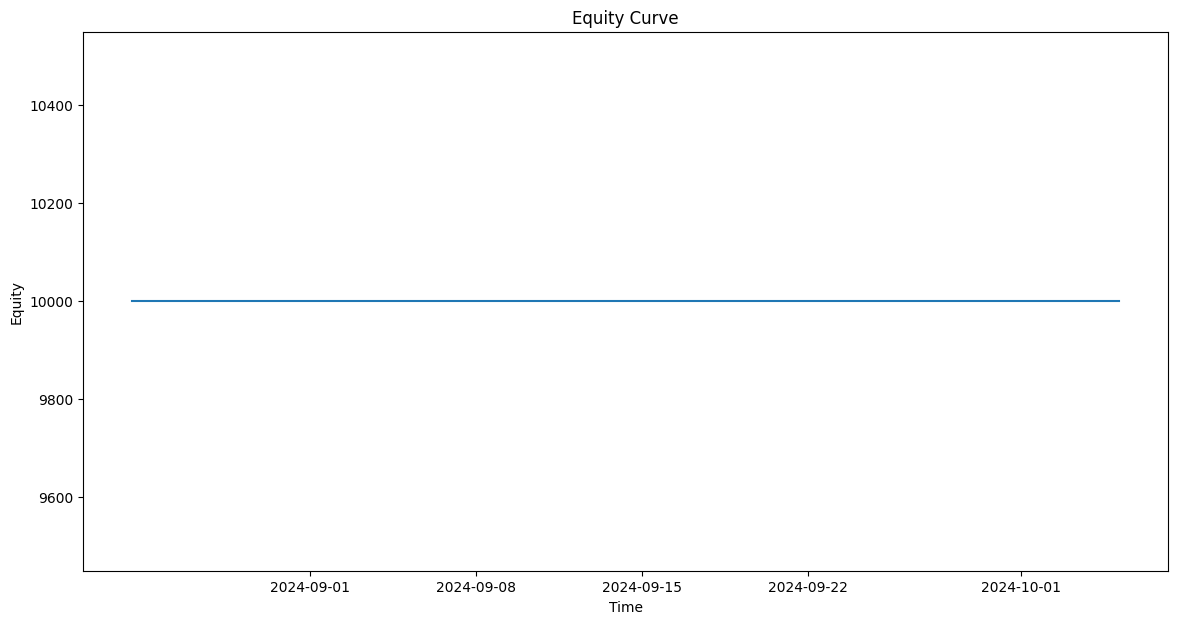

In [ ]:
bt = Backtest(
    data,
    LSTMStrategy,
    cash=10000,
    commission=.002,
    trade_on_close=True,  # False にするとシグナル発生後の次のバーのオープンで取引をする。default は False.
)
stats = bt.run()
# bt.plot()
print(stats)
# プロットの例
plt.figure(figsize=(14, 7))
plt.plot(stats['_equity_curve']['Equity'])
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.show()